# Trabajo Práctico 1: Reservas de Hotel - CHP4
## Grupo 05 - Medialunas 🥐

### Integrantes:
| Integrante                              | Número de Padrón |
|----------------------------------------|------------------|
| Iara Elizabeth Jolodovsky      | 109385           |
| Tomas Vainstein Aranguren      | 109043           |
| Martin Abramovich              | 108762           |

## Librerias

In [1]:
!pip install 'dtreeviz'
!pip install keras==2.12.0
!pip uninstall tensorflow -y
!pip install tensorflow==2.12.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 8.2 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.14.0
    Uninstalling keras-2.14.0:
      Successfully uninstalled keras-2.14.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.14.0 requires keras<2.15,>=2.14.0, but you have keras 2.12.0 which is incompatible.
Found existing installation: tensorflow 2.14.0
Uninstalling tensorflow-2.14.0:
  Successfully uninstalled tensorflow-2.14.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.9/585.9 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 92.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 44.2 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Fo

In [2]:
import pandas as pd
import numpy as np
import sklearn as sk
import seaborn as sns
import pydotplus
from six import StringIO
from IPython.display import Image
from matplotlib import pyplot as plt
from joblib import dump, load
from os.path import exists

from sklearn.model_selection import StratifiedKFold, KFold,RandomizedSearchCV, train_test_split, cross_validate
from sklearn.tree import DecisionTreeClassifier, export_graphviz, export_text
from sklearn.metrics import confusion_matrix, classification_report , f1_score, make_scorer, precision_score, recall_score, accuracy_score,f1_score
from sklearn.preprocessing import MinMaxScaler
from sklearn import tree
from sklearn.preprocessing import OneHotEncoder, StandardScaler


from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
#Para eliminar los warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

import tensorflow as tf
from tensorflow import keras

np.random.seed(1)
tf.random.set_seed(1)

#configuración warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

## Funciones

In [3]:
def metricas(y_pred,y_test):

  print(classification_report(y_test,y_pred))

  cm = confusion_matrix(y_test,y_pred)
  sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
  plt.xlabel('Predicted')
  plt.ylabel('True')

**Cargamos el dataset de hotels train ya procesado en el CHP1 y el dataset hotels_test el cual debemos preprocesar igual que el train**

In [4]:
ds_hotels_train = pd.read_csv('./df_final_chp1.csv')
ds_training = ds_hotels_train.copy(deep=True)
ds_training['arrival_date'] = pd.to_datetime(ds_training['arrival_date'])

In [5]:
ds_hotels_test = pd.read_csv('./hotels_test.csv')
ds_testing_conId = ds_hotels_test.copy(deep=True)
ds_testing_conId.shape

(26535, 31)

Concatenamos arrival_date_year, arrival_date_month y arrival_date_day_of_month y unificamos en una variable arrival_date

In [6]:
ds_testing_conId['arrival_date'] = ds_testing_conId['arrival_date_year'].astype(str) + '-' + ds_testing_conId['arrival_date_month'] + '-' + ds_testing_conId['arrival_date_day_of_month'].astype(str)
ds_testing_conId.drop(columns=['arrival_date_year', 'arrival_date_month', 'arrival_date_day_of_month'], inplace=True)
ds_testing_conId['arrival_date'] = pd.to_datetime(ds_testing_conId['arrival_date'])

Y pasamos child de float a int

In [7]:
ds_testing_conId['children'] = ds_testing_conId['children'].astype(int)

Juntamos children y babies

In [8]:
ds_testing_conId['minors'] = ds_testing_conId['children'] + ds_testing_conId['babies']

ds_testing_conId = ds_testing_conId.drop(columns=['children', 'babies'])

In [9]:
ds_testing_conId.head()

,hotel,lead_time,arrival_date_week_number,stays_in_weekend_nights,stays_in_week_nights,adults,meal,country,market_segment,distribution_channel,...,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status_date,id,arrival_date,minors
0,City Hotel,277,46,1,2,2,BB,PRT,Groups,TA/TO,...,NaN,0,Transient,100.0,0,0,2016-04-04,e6d0d58a-ab96-44d3-b28f-85df1cc15f1e,2016-11-07,0
1,City Hotel,286,20,0,4,2,BB,PRT,Groups,TA/TO,...,NaN,176,Transient-Party,101.0,0,0,2016-01-22,aba9aac2-4495-4645-a60e-90328713c999,2016-05-11,0
2,City Hotel,0,35,0,1,3,BB,FRA,Online TA,TA/TO,...,NaN,0,Transient,225.0,0,2,2016-08-24,b345b5dc-c804-4d77-a39f-1f4e65d1f1ad,2016-08-23,0
3,Resort Hotel,196,44,2,5,2,BB,DEU,Online TA,TA/TO,...,NaN,0,Transient,96.0,0,0,2016-11-05,ce1b400e-afa1-4946-bdff-004b859eb61c,2016-10-29,2
4,Resort Hotel,232,48,2,1,2,BB,PRT,Groups,TA/TO,...,NaN,0,Transient,30.0,0,0,2016-10-18,c4fbec0d-8e2e-4db2-9d4f-a6ccb9f51214,2016-11-26,0


In [10]:
ds_testing_conId.shape

(26535, 28)

In [11]:
ds_training.dtypes

Unnamed: 0                                 int64
hotel                                     object
lead_time                                  int64
arrival_date_week_number                   int64
stays_in_weekend_nights                    int64
stays_in_week_nights                       int64
adults                                     int64
meal                                      object
country                                   object
market_segment                            object
distribution_channel                      object
is_repeated_guest                          int64
previous_cancellations                     int64
previous_bookings_not_canceled             int64
reserved_room_type                        object
assigned_room_type                        object
booking_changes                            int64
deposit_type                              object
agent                                    float64
company                                  float64
days_in_waiting_list

In [12]:
ds_testing_conId= ds_testing_conId.drop(columns=['reservation_status_date'])

### One Hot Encoding para variables categóricas

Los NaN de agent y company tenemos que manejarlos. En este caso decidimos convertirlos a -1

In [13]:
ds_training['agent'].fillna(-1, inplace=True)
ds_training['company'].fillna(-1, inplace=True)
ds_testing_conId['agent'].fillna(-1, inplace=True)
ds_testing_conId['company'].fillna(-1, inplace=True)

In [14]:
ds_training = pd.get_dummies(ds_training, columns=["hotel","meal","country", "market_segment", "distribution_channel", "reserved_room_type", "assigned_room_type", "deposit_type", "customer_type"], drop_first=True)
ds_training.head()

,Unnamed: 0,lead_time,arrival_date_week_number,stays_in_weekend_nights,stays_in_week_nights,adults,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,...,assigned_room_type_G,assigned_room_type_H,assigned_room_type_I,assigned_room_type_K,assigned_room_type_L,deposit_type_Non Refund,deposit_type_Refundable,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
0,0,49,37,1,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,1,4,44,0,1,2,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,2,25,42,0,1,2,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,3,26,51,2,5,2,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
4,4,104,12,2,5,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [15]:
ds_testing_conId = pd.get_dummies(ds_testing_conId, columns=["hotel","meal","country", "market_segment", "distribution_channel", "reserved_room_type", "assigned_room_type", "deposit_type", "customer_type"], drop_first=True)
ds_testing_conId.head()

,lead_time,arrival_date_week_number,stays_in_weekend_nights,stays_in_week_nights,adults,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,...,assigned_room_type_G,assigned_room_type_H,assigned_room_type_I,assigned_room_type_K,assigned_room_type_P,deposit_type_Non Refund,deposit_type_Refundable,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
0,277,46,1,2,2,0,0,0,0,-1.0,...,0,0,0,0,0,1,0,0,1,0
1,286,20,0,4,2,0,0,0,0,30.0,...,0,0,0,0,0,0,0,0,0,1
2,0,35,0,1,3,0,0,0,0,-1.0,...,0,0,0,0,0,0,0,0,1,0
3,196,44,2,5,2,0,0,0,0,240.0,...,1,0,0,0,0,0,0,0,1,0
4,232,48,2,1,2,0,0,0,0,11.0,...,0,0,0,0,0,1,0,0,1,0


Necesitamos que la fecha sea un int

In [16]:
ds_training['arrival_date_unix'] = (ds_training['arrival_date'] - pd.Timestamp('1970-01-01')) // pd.Timedelta(days=1)
ds_training = ds_training.drop(columns=['arrival_date'], inplace=False)

ds_testing_conId['arrival_date_unix'] = (ds_testing_conId['arrival_date'] - pd.Timestamp('1970-01-01')) // pd.Timedelta(days=1)
ds_testing_conId = ds_testing_conId.drop(columns=['arrival_date'], inplace=False)

In [17]:
ds_testing_sinId = ds_testing_conId.drop(columns=['id'], inplace=False)

In [18]:
nans_por_columna = ds_training.isna().sum()

# Filtrar las columnas con valores NaN
columnas_con_nans = nans_por_columna[nans_por_columna > 0]

# Imprimir las columnas con NaN y la cantidad de NaN en cada una
if not columnas_con_nans.empty:
    print("Columnas con valores NaN y la cantidad de NaN en cada una:")
    print(columnas_con_nans)
else:
    print("No hay columnas con valores NaN en ds_training.")

No hay columnas con valores NaN en ds_training.


Dividimos el ds train para testear nuestros modelos

In [19]:
# Dividir los datos en entrenamiento y prueba
ds_entrenamiento, ds_testeo = train_test_split(
    ds_training,  # DataFrame original
    test_size=0.2,  # Proporción de datos de prueba
    random_state=10  # Semilla aleatoria para reproducibilidad
)

# Definir X e Y para ambos conjuntos
X_entrenamiento = ds_entrenamiento.drop(['is_canceled'], axis=1)
X_testeo = ds_testeo.drop(['is_canceled'], axis=1)
Y_entrenamiento = ds_entrenamiento['is_canceled']
Y_testeo = ds_testeo['is_canceled']

# Eliminar la columna 'id' en ambos conjuntos
X_entrenamiento = X_entrenamiento.drop(columns=['id'])
X_testeo = X_testeo.drop(columns=['id'])

## Modelo

In [20]:
sscaler=StandardScaler()
sscaler.fit(pd.DataFrame(X_entrenamiento))

StandardScaler()

In [21]:
x_train_transform=sscaler.transform(pd.DataFrame(X_entrenamiento))
x_test_transform=sscaler.transform(pd.DataFrame(X_entrenamiento))

x_train_norm = pd.DataFrame(x_train_transform, columns=X_entrenamiento.columns)
x_test_norm = pd.DataFrame(x_test_transform, columns=X_entrenamiento.columns)

In [22]:
x_train_norm.head(2)

,Unnamed: 0,lead_time,arrival_date_week_number,stays_in_weekend_nights,stays_in_week_nights,adults,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,...,assigned_room_type_H,assigned_room_type_I,assigned_room_type_K,assigned_room_type_L,deposit_type_Non Refund,deposit_type_Refundable,customer_type_Group,customer_type_Transient,customer_type_Transient-Party,arrival_date_unix
0,0.883909,-0.844583,0.797077,0.082221,0.264627,0.222418,-0.161098,-0.115414,-0.080066,-0.316931,...,-0.078579,-0.036512,-0.032589,-0.004561,-0.451466,-0.035351,-0.065122,0.555636,-0.498042,0.076384
1,0.126753,-1.015156,-1.568126,-0.934090,-0.816344,0.222418,-0.161098,-0.115414,-0.080066,-0.316931,...,-0.078579,-0.036512,-0.032589,-0.004561,-0.451466,-0.035351,-0.065122,0.555636,-0.498042,-0.909822


In [23]:
# Calcula la cantidad de clases
cant_clases=len(np.unique(Y_entrenamiento))
d_in=len(X_entrenamiento.columns)

In [24]:
#Limpiar bloques
from IPython.display import clear_output

class TrainingPlot(keras.callbacks.Callback):

    # This function is called when the training begins
    def on_train_begin(self, logs={}):
        # Initialize the lists for holding the logs, losses and accuracies
        self.losses = []
        self.Accuracy = []
        self.val_losses = []
        self.val_Accuracy = []
        self.logs = []

    # This function is called at the end of each epoch
    def on_epoch_end(self, epoch, logs={}):

        # Append the logs, losses and accuracies to the lists
        self.logs.append(logs)
        self.losses.append(logs.get('loss'))
        self.Accuracy.append(logs.get('Accuracy'))
        self.val_losses.append(logs.get('val_loss'))
        self.val_Accuracy.append(logs.get('val_Accuracy'))

        # Before plotting ensure at least 2 epochs have passed
        if len(self.losses) > 1:

            N = np.arange(0, len(self.losses))

            # You can chose the style of your preference
            # print(plt.style.available) to see the available options
            #plt.style.use("seaborn")

            # Plot train loss, train acc, val loss and val acc against epochs passed
            plt.figure()
            plt.plot(N, self.losses, label = "train_loss")
            plt.plot(N, self.Accuracy, label = "train_acc")
            plt.plot(N, self.val_losses, label = "val_loss")
            plt.plot(N, self.val_Accuracy, label = "val_Accuracy")
            plt.title("Training Loss and Accuracy [Epoch {}]".format(epoch))
            plt.xlabel("Epoch #")
            plt.ylabel("Loss/Accuracy")
            plt.legend()
            # Make sure there exists a folder called output in the current directory
            # or replace 'output' with whatever direcory you want to put in the plots
            # plt.savefig('./output/Epoch-{}.png'.format(epoch))
            clear_output(True)
            plt.show()
            plt.close()

plotPerformance = TrainingPlot()

In [25]:
import keras.backend as K

class RoundingActivationLayer(keras.layers.Layer):
    def __init__(self):
        super(RoundingActivationLayer, self).__init__()

    def build(self, input_shape):
        super(RoundingActivationLayer, self).build(input_shape)

    def call(self, inputs):
        return K.cast(K.greater(inputs, 0.5), K.floatx())

In [26]:
x_train_norm.shape

(48071, 202)

In [35]:
# Calcula la cantidad de clases
cant_clases=len(np.unique(Y_entrenamiento))
d_in=len(X_entrenamiento.columns)

# Se crea el modelo
modelo_rn_1 = keras.Sequential([
    keras.layers.Dense(1,input_shape=(d_in,), activation="relu"),
    keras.layers.Dense(1, activation='sigmoid')
])

modelo_rn_1.summary()

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_64 (Dense)            (None, 1)                 203       
                                                                 
 dense_65 (Dense)            (None, 1)                 2         
                                                                 
Total params: 205
Trainable params: 205
Non-trainable params: 0
_________________________________________________________________


In [36]:
# Se compila el modelo
modelo_rn_1.compile(
  loss='binary_crossentropy',
  optimizer=keras.optimizers.SGD(learning_rate=0.01),
  # metricas para ir calculando en cada iteracion o batch
  metrics=['AUC', 'Accuracy'],
)

cant_epochs_modelo_1 = 50
from sklearn.model_selection import train_test_split

# Dividir los datos en un conjunto de entrenamiento y un conjunto de etiquetas
x_train, x_labels, y_train, y_labels = train_test_split(x_train_norm, Y_entrenamiento, test_size=0.25, random_state=42)

# Verificar las dimensiones de los conjuntos de entrenamiento y etiquetas
print(len(x_train), len(y_train))

# Entrenar el modelo con los datos divididos
cant_epochs_modelo_1 = 50
modelo_rn_1_historia = modelo_rn_1.fit(
    x_train,
    y_train,
    epochs=cant_epochs_modelo_1,
    batch_size=64,
    validation_data=(x_test_norm, Y_entrenamiento))

36053 36053
Epoch 1/50
564/564 [==============================] - 5s 6ms/step - loss: 0.6767 - auc: 0.6772 - Accuracy: 0.6351 - val_loss: 0.5995 - val_auc: 0.7686 - val_Accuracy: 0.7284
Epoch 2/50
564/564 [==============================] - 4s 7ms/step - loss: 0.5581 - auc: 0.8048 - Accuracy: 0.7533 - val_loss: 0.5255 - val_auc: 0.8267 - val_Accuracy: 0.7690
Epoch 3/50
564/564 [==============================] - 4s 7ms/step - loss: 0.5052 - auc: 0.8386 - Accuracy: 0.7779 - val_loss: 0.4888 - val_auc: 0.8489 - val_Accuracy: 0.7846
Epoch 4/50
564/564 [==============================] - 3s 5ms/step - loss: 0.4767 - auc: 0.8550 - Accuracy: 0.7885 - val_loss: 0.4689 - val_auc: 0.8596 - val_Accuracy: 0.7923
Epoch 5/50
564/564 [==============================] - 2s 4ms/step - loss: 0.4611 - auc: 0.8640 - Accuracy: 0.7944 - val_loss: 0.4563 - val_auc: 0.8671 - val_Accuracy: 0.7979
Epoch 6/50
564/564 [==============================] - 2s 4ms/step - loss: 0.4487 - auc: 0.8717 - Accuracy: 0.7988 - va

1503/1503 [==============================] - 2s 1ms/step
              precision    recall  f1-score   support

           0       0.79      0.81      0.80     23629
           1       0.81      0.80      0.81     24442

    accuracy                           0.80     48071
   macro avg       0.80      0.80      0.80     48071
weighted avg       0.80      0.80      0.80     48071



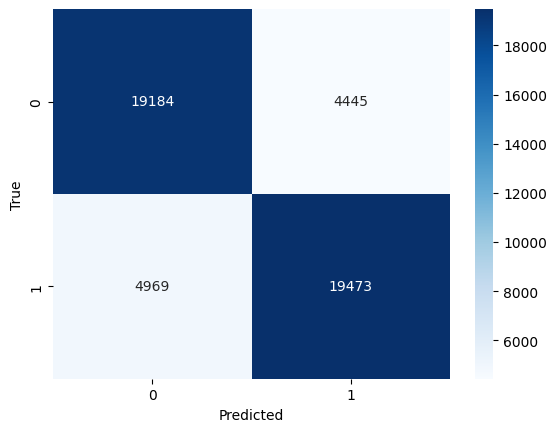

In [29]:
modelo_rn_1.add(RoundingActivationLayer())

y_predic_modelo_rn_1 = modelo_rn_1.predict(x_test_norm)

metricas(y_predic_modelo_rn_1, Y_entrenamiento)

## Kaggle

In [34]:
from sklearn.preprocessing import StandardScaler

# Create a StandardScaler instance
sscaler = StandardScaler()

ds_test_procesado = ds_testing_sinId.copy()

# Select only the numeric columns for scaling
numeric_columns = ds_testing_sinId.select_dtypes(include=['number'])

# Fit the StandardScaler to the numeric data
sscaler.fit(numeric_columns)

# Transform the numeric columns
ds_test_transformed = sscaler.transform(numeric_columns)

# Replace the original numeric columns with the scaled values
ds_test_procesado[numeric_columns.columns] = ds_test_transformed

In [35]:
ds_test_procesado = ds_test_procesado.reindex(columns= x_train.columns, fill_value=0)

In [36]:
y_predic_test = modelo_rn_1.predict(ds_test_procesado)
y_test_prediccion = np.where(y_predic_test > 0.481435, 1, 0)

830/830 [==============================] - 2s 2ms/step


In [37]:
arreglo_unidimensional = [elemento for sublista in y_test_prediccion for elemento in sublista]

In [39]:
df_submission = pd.DataFrame(
    {"id": ds_hotels_test["id"], "is_canceled": arreglo_unidimensional}
)

In [40]:
nombre_submit = "rn1.csv"
df_submission.to_csv(nombre_submit, index=False)

## Modelo 2

In [45]:
# Define una función que construye el modelo
def build_model(learning_rate=0.01, units=1, activation="relu"):
    model = keras.Sequential([
        keras.layers.Dense(units, input_shape=(d_in,), activation=activation),
        keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(
        loss='binary_crossentropy',
        optimizer=keras.optimizers.SGD(learning_rate=learning_rate),
        metrics=['AUC', 'Accuracy'],
    )
    return model

In [46]:
model = KerasClassifier(build_fn=build_model, verbose=0)

# Define la cuadrícula de hiperparámetros a explorar
param_grid = {
    'learning_rate': [0.001, 0.01, 0.1],
    'units': [32, 64, 128],
    'activation': ['relu', 'tanh', 'sigmoid']
}

In [47]:
# Realiza la búsqueda de hiperparámetros
random_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=10, cv=3)
random_search.fit(x_train_norm, Y_entrenamiento)

RandomizedSearchCV(cv=3,
                   estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x79e21719f400>,
                   param_distributions={'activation': ['relu', 'tanh',
                                                       'sigmoid'],
                                        'learning_rate': [0.001, 0.01, 0.1],
                                        'units': [32, 64, 128]})

In [48]:
# Muestra los mejores hiperparámetros encontrados
print("Mejores hiperparámetros encontrados:")
print(random_search.best_params_)

Mejores hiperparámetros encontrados:
{'units': 128, 'learning_rate': 0.1, 'activation': 'tanh'}


In [49]:
best_model = build_model(learning_rate=random_search.best_params_['learning_rate'],
                         units=random_search.best_params_['units'],
                         activation=random_search.best_params_['activation'])
history = best_model.fit(x_train_norm, Y_entrenamiento, epochs=cant_epochs_modelo_1, batch_size=64, validation_data=(x_test_norm, Y_entrenamiento))

Epoch 1/50
752/752 [==============================] - 7s 6ms/step - loss: 0.4222 - auc: 0.8823 - Accuracy: 0.7908 - val_loss: 0.4030 - val_auc: 0.8937 - val_Accuracy: 0.7982
Epoch 2/50
752/752 [==============================] - 3s 4ms/step - loss: 0.3876 - auc: 0.9014 - Accuracy: 0.8095 - val_loss: 0.3755 - val_auc: 0.9074 - val_Accuracy: 0.8128
Epoch 3/50
752/752 [==============================] - 3s 4ms/step - loss: 0.3687 - auc: 0.9108 - Accuracy: 0.8175 - val_loss: 0.3632 - val_auc: 0.9137 - val_Accuracy: 0.8182
Epoch 4/50
752/752 [==============================] - 5s 7ms/step - loss: 0.3554 - auc: 0.9176 - Accuracy: 0.8252 - val_loss: 0.3541 - val_auc: 0.9193 - val_Accuracy: 0.8265
Epoch 5/50
752/752 [==============================] - 4s 5ms/step - loss: 0.3453 - auc: 0.9227 - Accuracy: 0.8322 - val_loss: 0.3495 - val_auc: 0.9203 - val_Accuracy: 0.8264
Epoch 6/50
752/752 [==============================] - 3s 4ms/step - loss: 0.3382 - auc: 0.9259 - Accuracy: 0.8365 - val_loss: 0.33

1503/1503 [==============================] - 2s 2ms/step
              precision    recall  f1-score   support

           0       0.91      0.85      0.88     23629
           1       0.87      0.92      0.89     24442

    accuracy                           0.89     48071
   macro avg       0.89      0.89      0.89     48071
weighted avg       0.89      0.89      0.89     48071



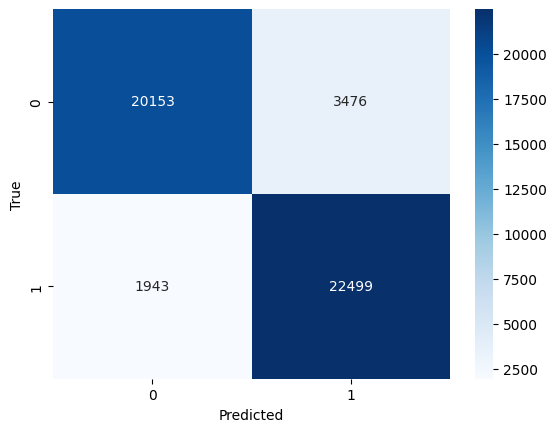

In [50]:
best_model.add(RoundingActivationLayer())

y_predic_best_model = best_model.predict(x_test_norm)

metricas(y_predic_best_model, Y_entrenamiento)

### Kaggle

In [51]:
from sklearn.preprocessing import StandardScaler

# Create a StandardScaler instance
sscaler = StandardScaler()

ds_test_procesado = ds_testing_sinId.copy()

# Select only the numeric columns for scaling
numeric_columns = ds_testing_sinId.select_dtypes(include=['number'])

# Fit the StandardScaler to the numeric data
sscaler.fit(numeric_columns)

# Transform the numeric columns
ds_test_transformed = sscaler.transform(numeric_columns)

# Replace the original numeric columns with the scaled values
ds_test_procesado[numeric_columns.columns] = ds_test_transformed

In [52]:
ds_test_procesado = ds_test_procesado.reindex(columns= x_train.columns, fill_value=0)

In [53]:
y_predic_test = best_model.predict(ds_test_procesado)
y_test_prediccion = np.where(y_predic_test > 0.481435, 1, 0)

830/830 [==============================] - 2s 3ms/step


In [54]:
arreglo_unidimensional = [elemento for sublista in y_test_prediccion for elemento in sublista]

In [55]:
df_submission = pd.DataFrame(
    {"id": ds_hotels_test["id"], "is_canceled": arreglo_unidimensional}
)

In [56]:
nombre_submit = "rn2.csv"
df_submission.to_csv(nombre_submit, index=False)

## Modelo 3

In [57]:
import keras.backend as K

In [61]:
def build_model(learning_rate=0.01, units=1, activation="relu", epochs=50, batch_size=64):
    model = keras.Sequential([
        keras.layers.Dense(units, input_shape=(d_in,), activation=activation),
        keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(
        loss='binary_crossentropy',
        optimizer=keras.optimizers.SGD(learning_rate=learning_rate),
        metrics=['AUC', 'Accuracy'],
    )
    return model

In [62]:
# Crea un modelo KerasClassifier que se puede utilizar con RandomizedSearchCV
model = KerasClassifier(build_fn=build_model, verbose=0)

# Define la cuadrícula de hiperparámetros a explorar
param_grid = {
    'learning_rate': [0.001, 0.01, 0.1],
    'units': [32, 64, 128],
    'activation': ['relu', 'tanh', 'sigmoid'],
    'epochs': [50, 100, 200],  # Rango de épocas
    'batch_size': [32, 64, 128]  # Tamaños de lote
}

In [63]:
# Realiza la búsqueda de hiperparámetros
random_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=10, cv=3)
random_search.fit(x_train_norm, Y_entrenamiento)

# Muestra los mejores hiperparámetros encontrados
print("Mejores hiperparámetros encontrados:")
print(random_search.best_params_)

Mejores hiperparámetros encontrados:
{'units': 128, 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 32, 'activation': 'tanh'}


In [64]:
# Entrena el modelo con los mejores hiperparámetros encontrados
best_model = build_model(learning_rate=random_search.best_params_['learning_rate'],
                         units=random_search.best_params_['units'],
                         activation=random_search.best_params_['activation'],
                         epochs=random_search.best_params_['epochs'],
                         batch_size=random_search.best_params_['batch_size'])
history = best_model.fit(x_train_norm, Y_entrenamiento, epochs=random_search.best_params_['epochs'], batch_size=random_search.best_params_['batch_size'], validation_data=(x_test_norm, Y_entrenamiento))

Epoch 1/100
1503/1503 [==============================] - 7s 4ms/step - loss: 0.4586 - auc: 0.8617 - Accuracy: 0.7697 - val_loss: 0.4150 - val_auc: 0.8883 - val_Accuracy: 0.7979
Epoch 2/100
1503/1503 [==============================] - 8s 5ms/step - loss: 0.4106 - auc: 0.8902 - Accuracy: 0.7997 - val_loss: 0.4040 - val_auc: 0.8942 - val_Accuracy: 0.8028
Epoch 3/100
1503/1503 [==============================] - 7s 5ms/step - loss: 0.4024 - auc: 0.8945 - Accuracy: 0.8036 - val_loss: 0.3981 - val_auc: 0.8966 - val_Accuracy: 0.8042
Epoch 4/100
1503/1503 [==============================] - 5s 4ms/step - loss: 0.3969 - auc: 0.8974 - Accuracy: 0.8055 - val_loss: 0.3923 - val_auc: 0.9003 - val_Accuracy: 0.8100
Epoch 5/100
1503/1503 [==============================] - 8s 5ms/step - loss: 0.3919 - auc: 0.9002 - Accuracy: 0.8086 - val_loss: 0.3873 - val_auc: 0.9027 - val_Accuracy: 0.8118
Epoch 6/100
1503/1503 [==============================] - 6s 4ms/step - loss: 0.3869 - auc: 0.9028 - Accuracy: 0.812

1503/1503 [==============================] - 3s 2ms/step
              precision    recall  f1-score   support

           0       0.89      0.89      0.89     23629
           1       0.89      0.90      0.90     24442

    accuracy                           0.89     48071
   macro avg       0.89      0.89      0.89     48071
weighted avg       0.89      0.89      0.89     48071



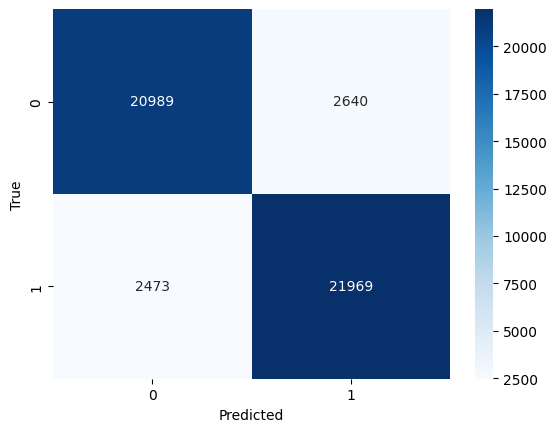

In [65]:
best_model.add(RoundingActivationLayer())

y_predic_best_model = best_model.predict(x_test_norm)

metricas(y_predic_best_model, Y_entrenamiento)

### Kaggle

In [66]:
from sklearn.preprocessing import StandardScaler

# Create a StandardScaler instance
sscaler = StandardScaler()

ds_test_procesado = ds_testing_sinId.copy()

# Select only the numeric columns for scaling
numeric_columns = ds_testing_sinId.select_dtypes(include=['number'])

# Fit the StandardScaler to the numeric data
sscaler.fit(numeric_columns)

# Transform the numeric columns
ds_test_transformed = sscaler.transform(numeric_columns)

# Replace the original numeric columns with the scaled values
ds_test_procesado[numeric_columns.columns] = ds_test_transformed

In [67]:
ds_test_procesado = ds_test_procesado.reindex(columns= x_train.columns, fill_value=0)

In [68]:
y_predic_test = best_model.predict(ds_test_procesado)
y_test_prediccion = np.where(y_predic_test > 0.481435, 1, 0)

830/830 [==============================] - 2s 2ms/step


In [69]:
arreglo_unidimensional = [elemento for sublista in y_test_prediccion for elemento in sublista]

In [70]:
df_submission = pd.DataFrame(
    {"id": ds_hotels_test["id"], "is_canceled": arreglo_unidimensional}
)

In [71]:
nombre_submit = "rn3.csv"
df_submission.to_csv(nombre_submit, index=False)

## Modelo 4

In [37]:
def build_dense_model(learning_rate=0.01, units=64, activation="relu", epochs=50, batch_size=64):
    model = keras.Sequential([
        keras.layers.Dense(units, input_shape=(d_in,), activation=activation),
        keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(
        loss='binary_crossentropy',
        optimizer=keras.optimizers.SGD(learning_rate=learning_rate),
        metrics=['AUC', 'Accuracy'],
    )
    return model

In [38]:
model = KerasClassifier(build_fn=build_dense_model, verbose=0)

# Define la cuadrícula de hiperparámetros a explorar para el modelo con capas densas
param_grid_dense = {
    'learning_rate': [0.001, 0.01, 0.1],
    'units': [32, 64, 128],
    'activation': ['relu', 'tanh', 'sigmoid'],
    'epochs': [50, 100, 200],
    'batch_size': [32, 64, 128]
}

In [39]:
random_search_dense = RandomizedSearchCV(model, param_distributions=param_grid_dense, n_iter=10, cv=3)
random_search_dense.fit(x_train_norm, Y_entrenamiento)

# Muestra los mejores hiperparámetros encontrados
print("Mejores hiperparámetros encontrados:")
print(random_search_dense.best_params_)

Mejores hiperparámetros encontrados:
{'units': 128, 'learning_rate': 0.1, 'epochs': 100, 'batch_size': 32, 'activation': 'sigmoid'}


In [40]:
best_dense_model = build_dense_model(learning_rate=random_search_dense.best_params_['learning_rate'],
                                     units=random_search_dense.best_params_['units'],
                                     activation=random_search_dense.best_params_['activation'],
                                     epochs=random_search_dense.best_params_['epochs'],
                                     batch_size=random_search_dense.best_params_['batch_size'])
history = best_dense_model.fit(x_train_norm, Y_entrenamiento, epochs=random_search_dense.best_params_['epochs'], batch_size=random_search_dense.best_params_['batch_size'], validation_data=(x_test_norm, Y_entrenamiento))


Epoch 1/100
1503/1503 [==============================] - 6s 4ms/step - loss: 0.4405 - auc: 0.8719 - Accuracy: 0.7831 - val_loss: 0.4513 - val_auc: 0.8921 - val_Accuracy: 0.7650
Epoch 2/100
1503/1503 [==============================] - 7s 5ms/step - loss: 0.4088 - auc: 0.8899 - Accuracy: 0.7978 - val_loss: 0.3995 - val_auc: 0.8957 - val_Accuracy: 0.8003
Epoch 3/100
1503/1503 [==============================] - 5s 4ms/step - loss: 0.4028 - auc: 0.8930 - Accuracy: 0.8008 - val_loss: 0.4093 - val_auc: 0.8985 - val_Accuracy: 0.7865
Epoch 4/100
1503/1503 [==============================] - 5s 4ms/step - loss: 0.3947 - auc: 0.8975 - Accuracy: 0.8040 - val_loss: 0.4181 - val_auc: 0.9044 - val_Accuracy: 0.7802
Epoch 5/100
1503/1503 [==============================] - 6s 4ms/step - loss: 0.3824 - auc: 0.9037 - Accuracy: 0.8110 - val_loss: 0.3848 - val_auc: 0.9101 - val_Accuracy: 0.8021
Epoch 6/100
1503/1503 [==============================] - 5s 3ms/step - loss: 0.3724 - auc: 0.9085 - Accuracy: 0.813

1503/1503 [==============================] - 3s 2ms/step
              precision    recall  f1-score   support

           0       0.90      0.91      0.90     23629
           1       0.91      0.90      0.90     24442

    accuracy                           0.90     48071
   macro avg       0.90      0.90      0.90     48071
weighted avg       0.90      0.90      0.90     48071



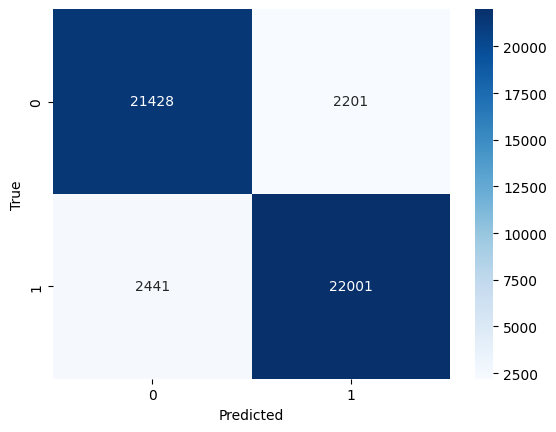

In [41]:
best_dense_model.add(RoundingActivationLayer())

y_predic_best_dense_model = best_dense_model.predict(x_test_norm)

metricas(y_predic_best_dense_model, Y_entrenamiento)

### Kaggle

In [42]:
from sklearn.preprocessing import StandardScaler

# Create a StandardScaler instance
sscaler = StandardScaler()

ds_test_procesado = ds_testing_sinId.copy()

# Select only the numeric columns for scaling
numeric_columns = ds_testing_sinId.select_dtypes(include=['number'])

# Fit the StandardScaler to the numeric data
sscaler.fit(numeric_columns)

# Transform the numeric columns
ds_test_transformed = sscaler.transform(numeric_columns)

# Replace the original numeric columns with the scaled values
ds_test_procesado[numeric_columns.columns] = ds_test_transformed

In [43]:
ds_test_procesado = ds_test_procesado.reindex(columns= x_train.columns, fill_value=0)

In [44]:
y_predic_test = best_dense_model.predict(ds_test_procesado)
y_test_prediccion = np.where(y_predic_test > 0.481435, 1, 0)

830/830 [==============================] - 1s 1ms/step


In [45]:
arreglo_unidimensional = [elemento for sublista in y_test_prediccion for elemento in sublista]

In [46]:
df_submission = pd.DataFrame(
    {"id": ds_hotels_test["id"], "is_canceled": arreglo_unidimensional}
)

In [47]:
nombre_submit = "rn4.csv"
df_submission.to_csv(nombre_submit, index=False)